# <font color="Darkblue">Character level language model</font>

**Job** : Give names to dinosaurs

**Dataset** : `dinos.txt`.

In [1]:
import numpy as np
from utils import *
import random
import pprint
from IPython.display import Image

## <font color='IndianRed'>Problem Statement</font>

### <font color='Indigo'>Dataset and Preprocessing</font>


In [2]:
data = open('dinos.txt', 'r').read()
data= data.lower()
chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
print('%d total characters, %d unique characters' % (data_size, vocab_size))

19909 total characters, 27 unique characters



* The characters are a-z (26 characters) plus the `\n` (or newline character).In this assignment, the newline character plays a role similar to the `<EOS>` (or End of sentence) token. 

* `char_to_ix`: In the cell below, we create a python dictionary (i.e., a hash table) to map each character to an index from 0-26.
* `ix_to_char`: We also create a second python dictionary that maps each index back to the corresponding character. This will help you figure out what index corresponds to what character in the probability distribution output of the softmax layer. 

In [3]:
chars = sorted(chars)
print(chars)

['\n', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [4]:
char_to_ix = { ch:i for i,ch in enumerate(chars) }
ix_to_char = { i:ch for i,ch in enumerate(chars) }
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(ix_to_char)

{   0: '\n',
    1: 'a',
    2: 'b',
    3: 'c',
    4: 'd',
    5: 'e',
    6: 'f',
    7: 'g',
    8: 'h',
    9: 'i',
    10: 'j',
    11: 'k',
    12: 'l',
    13: 'm',
    14: 'n',
    15: 'o',
    16: 'p',
    17: 'q',
    18: 'r',
    19: 's',
    20: 't',
    21: 'u',
    22: 'v',
    23: 'w',
    24: 'x',
    25: 'y',
    26: 'z'}


### <font color='Indigo'>Overview of the model</font>

Your model will have the following structure: 

- Initialize parameters 
- Run the optimization loop
    - Forward propagation to compute the loss function
    - Backward propagation to compute the gradients with respect to the loss function
    - Clip the gradients to avoid exploding gradients
    - Using the gradients, update your parameters with the gradient descent update rule.
- Return the learned parameters 
    

* At each time-step, the RNN tries to predict what is the next character given the previous characters. 
* The dataset $\mathbf{X} = (x^{\langle 1 \rangle}, x^{\langle 2 \rangle}, ..., x^{\langle T_x \rangle})$ is a list of characters in the training set.
* $\mathbf{Y} = (y^{\langle 1 \rangle}, y^{\langle 2 \rangle}, ..., y^{\langle T_x \rangle})$ is the same list of characters but shifted one character forward. At every time-step $t$, $y^{\langle t \rangle} = x^{\langle t+1 \rangle}$.  The prediction at time $t$ is the same as the input at time $t + 1$.

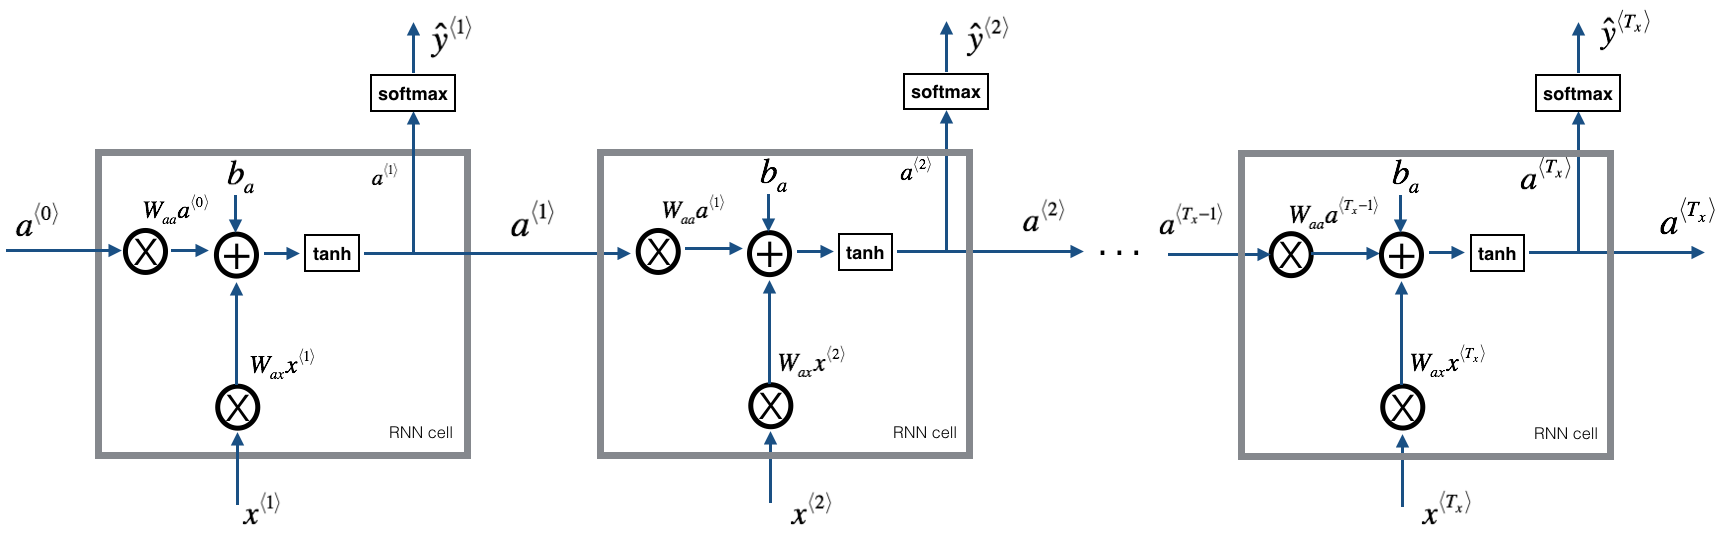

In [5]:
Image(filename="images/rnn.png", height=350, width = 700)

## <font color='IndianRed'>Building blocks of the model</font>

- **Gradient clipping**, to avoid exploding gradients
- **Sampling**, a technique used to generate characters

### <font color='Indigo'>Clipping the gradients in the optimization loop</font>

In this section you will implement the `clip` function that you will call inside of your optimization loop. 

#### Exploding gradients
* When gradients are very large, they're called `exploding gradients.`
* Exploding gradients make the training process more difficult, because the updates may be so large that they `overshoot` the optimal values during back propagation.

Recall that your overall loop structure usually consists of:
* forward pass, 
* cost computation, 
* backward pass, 
* parameter update. 

Before updating the parameters, you will perform gradient clipping to make sure that your gradients are not exploding.

#### Gradient clipping
In the exercise below, you will implement a function `clip` that takes in a dictionary of gradients and returns a clipped version of gradients if needed. 
* There are different ways to clip gradients.
* We will use a simple element-wise clipping procedure, in which every element of the gradient vector is clipped to lie between some range [-N, N]. 
* For example, if the N=10
    - The range is [-10, 10]
    - If any component of the gradient vector is greater than 10, it is set to 10.
    - If any component of the gradient vector is less than -10, it is set to -10. 
    - If any components are between -10 and 10, they keep their original values.

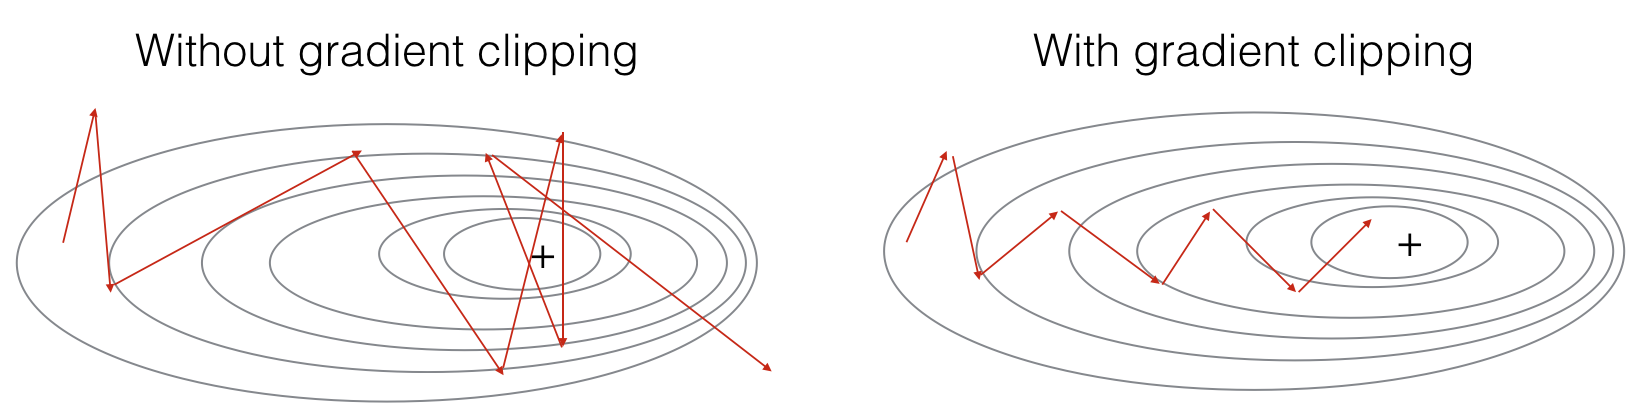

In [6]:
Image("images/clip.png", height=600, width=800)

**Exercise**: 
Implement the function below to return the clipped gradients of your dictionary `gradients`. 

In [7]:
def clip(gradients, maxValue):
    '''
    Clips the gradients' values between minimum and maximum.
    
    Arguments:
    gradients -- a dictionary containing the gradients "dWaa", "dWax", "dWya", "db", "dby"
    maxValue  -- everything above this number is set to this number, and everything less than 
                -maxValue is set to -maxValue
    
    Returns: 
    gradients -- a dictionary with the clipped gradients.
    '''
    
    dWaa, dWax, dWya, db, dby = gradients['dWaa'], gradients['dWax'], gradients['dWya'], \
                                gradients['db'], gradients['dby']
   
    for gradient in [dWaa, dWax, dWya, db, dby]:
        gradient = np.clip(gradient,-maxValue,maxValue,out = gradient)
    
    gradients = {"dWaa": dWaa, 
                 "dWax": dWax, 
                 "dWya": dWya, 
                 "db": db, 
                 "dby": dby}
    return gradients

In [8]:
# Test with a maxvalue of 10
mValue = 10
np.random.seed(3)
dWax = np.random.randn(5,3)*10
dWaa = np.random.randn(5,5)*10
dWya = np.random.randn(2,5)*10
db = np.random.randn(5,1)*10
dby = np.random.randn(2,1)*10
gradients = {"dWax": dWax, "dWaa": dWaa, "dWya": dWya, "db": db, "dby": dby}
gradients = clip(gradients, mValue)
print("gradients[\"dWaa\"][1][2] =", gradients["dWaa"][1][2])
print("gradients[\"dWax\"][3][1] =", gradients["dWax"][3][1])
print("gradients[\"dWya\"][1][2] =", gradients["dWya"][1][2])
print("gradients[\"db\"][4]      =", gradients["db"][4])
print("gradients[\"dby\"][1]     =", gradients["dby"][1])

gradients["dWaa"][1][2] = 10.0
gradients["dWax"][3][1] = -10.0
gradients["dWya"][1][2] = 0.29713815361
gradients["db"][4]      = [ 10.]
gradients["dby"][1]     = [ 8.45833407]


In [9]:
# Test with a maxValue of 5
mValue = 5
np.random.seed(3)
dWax = np.random.randn(5,3)*10
dWaa = np.random.randn(5,5)*10
dWya = np.random.randn(2,5)*10
db = np.random.randn(5,1)*10
dby = np.random.randn(2,1)*10
gradients = {"dWax": dWax, "dWaa": dWaa, "dWya": dWya, "db": db, "dby": dby}
gradients = clip(gradients, mValue)
print("gradients[\"dWaa\"][1][2] =", gradients["dWaa"][1][2])
print("gradients[\"dWax\"][3][1] =", gradients["dWax"][3][1])
print("gradients[\"dWya\"][1][2] =", gradients["dWya"][1][2])
print("gradients[\"db\"][4]      =", gradients["db"][4])
print("gradients[\"dby\"][1]     =", gradients["dby"][1])
del mValue # avoid common issue

gradients["dWaa"][1][2] = 5.0
gradients["dWax"][3][1] = -5.0
gradients["dWya"][1][2] = 0.29713815361
gradients["db"][4]      = [ 5.]
gradients["dby"][1]     = [ 5.]


### <font color='indigo'>Sampling</font>

Now assume that your model is trained. You would like to generate new text (characters). The process of generation is explained as: We assume the model is already trained. We pass in $x^{\langle 1\rangle} = \vec{0}$ at the first time step, and have the network sample one character at a time.

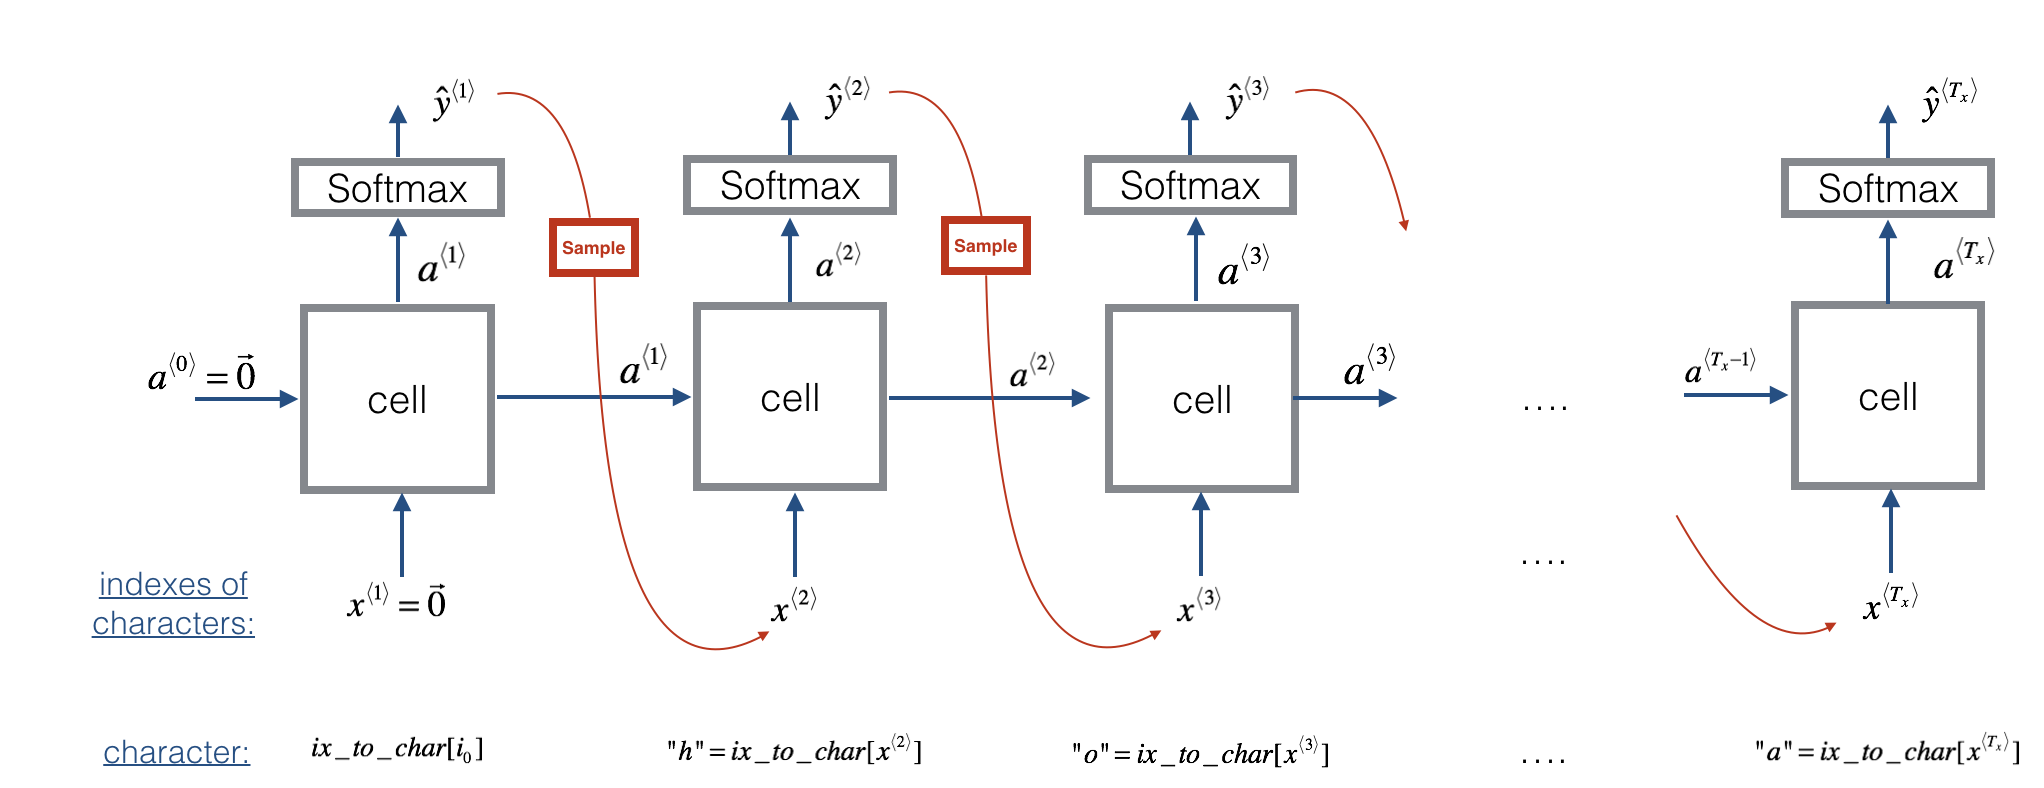

In [10]:
Image("images/dinos3.png", height = 800, width = 800)

**Exercise**: Implement the `sample` function below to sample characters.

<font color='IndianRed'>Step 1</font>: 

Input the dummy vector of zeros $x^{\langle 1 \rangle} = \vec{0}$. This is the default input before we've generated any characters. We also set $a^{\langle 0 \rangle} = \vec{0}$

<font color='IndianRed'>Step 2 :</font>

Run one step of forward propagation to get $a^{\langle 1 \rangle}$ and $\hat{y}^{\langle 1 \rangle}$. Here are the equations:

   - Note that $\hat{y}^{\langle t+1 \rangle }$ is a (softmax) probability vector (its entries are between 0 and 1 and sum to 1). 
   - $\hat{y}^{\langle t+1 \rangle}_i$ represents the probability that the character indexed by "i" is the next character.

\begin{align}
\displaystyle a^{\langle t+1 \rangle} &= \tanh(W_{ax}  x^{\langle t+1 \rangle } + W_{aa} a^{\langle t \rangle } + b)\\[8pt]
\displaystyle z^{\langle t + 1 \rangle } &= W_{ya}  a^{\langle t + 1 \rangle } + b_y\\[8pt]
\displaystyle \hat{y}^{\langle t+1 \rangle } &= softmax(z^{\langle t + 1 \rangle })\\[8pt]
\end{align}

#### Additional Hints

- $x^{\langle 1 \rangle}$ is `x` in the code. When creating the one-hot vector, make a numpy array of zeros, with the number of rows equal to the number of unique characters, and the number of columns equal to one.  It's a 2D and not a 1D array, by design.
- $a^{\langle 0 \rangle}$ is `a_prev` in the code.  It is a numpy array of zeros, where the number of rows is $n_{a}$, and number of columns is 1.  It is a 2D array as well.  $n_{a}$ is retrieved by getting the number of columns in $W_{aa}$ (the numbers need to match in order for the matrix multiplication $W_{aa}a^{\langle t \rangle}$ to work.

#### <font color='Maroon'>Using 2D arrays instead of 1D arrays</font>
<font color='maroon'>You may be wondering why we emphasize that $x^{\langle 1 \rangle}$ and $a^{\langle 0 \rangle}$ are 2D arrays and not 1D vectors. For matrix multiplication in numpy, if we multiply a 2D matrix with a 1D vector, we end up with with a 1D array. This becomes a problem when we add two arrays where we expected them to have the same shape. When two arrays with  a different number of dimensions are added together, Python broadcasts one across the other.</font>

<font color='IndianRed'>Step 3 : </font>

Sampling - Now that we have $y^{\langle t+1 \rangle}$, we want to select the next letter in the name. If we select the most probable, the model will always generate the same result given a starting letter. To make the results more interesting, we will use np.random.choice to select a next letter that is *likely*, but not always the same.

- Pick the next character's **index** according to the probability distribution specified by $\hat{y}^{\langle t+1 \rangle }$. 
- This means that if $\hat{y}^{\langle t+1 \rangle }_i = 0.16$, you will pick the index i with 16% probability. 
- Note that the value that's set to `p` should be set to a 1D vector.
- Also notice that $\hat{y}^{\langle t+1 \rangle}$, which is `y` in the code, is a 2D array.

<font color='IndianRed'>Step 4 </font>: 

Update to $x^{\langle t \rangle }$:

The last step to implement in `sample()` is to update the variable `x`, which currently stores $x^{\langle t \rangle }$, with the value of $x^{\langle t + 1 \rangle }$. You will represent $x^{\langle t + 1 \rangle }$ by creating a one-hot vector corresponding to the character that you have chosen as your prediction. You will then forward propagate $x^{\langle t + 1 \rangle }$ in Step 1 and keep repeating the process until you get a "\n" character, indicating that you have reached the end of the name. 

##### Additional Hints
- In order to reset `x` before setting it to the new one-hot vector, you'll want to set all the values to zero.
    - You can either create a new numpy array i.e. by `numpy.zeros`
    - Or fill all values with a single number i.e. by `numpy.ndarray.fill`

In [11]:
#sample

def sample(parameters, char_to_ix, seed):
    """
    Sample a sequence of characters according to a sequence of probability distributions output of 
    the RNN

    Arguments:
    parameters -- python dictionary containing the parameters Waa, Wax, Wya, by, and b. 
    char_to_ix -- python dictionary mapping each character to an index.

    Returns:
    indices -- a list of length n containing the indices of the sampled characters.
    """
    
    # Retrieve parameters and relevant shapes from "parameters" dictionary
    Waa, Wax, Wya, by, b = parameters['Waa'], parameters['Wax'], parameters['Wya'], \
                           parameters['by'], parameters['b']
    
    vocab_size = by.shape[0]
    n_a = Waa.shape[1]
    

    # Step 1 : Create the a zero vector x that can be used as the one-hot vector 
    # representing the first character (initializing the sequence generation).
    x = np.zeros(( vocab_size, 1))
    
    # Step 1 : Initialize a_prev as zeros
    a_prev = np.zeros(( n_a, 1))
    
    # Create an empty list of indices,     
    indices = []
    
    # idx is the index of the one-hot vector x that is set to 1
    # All other positions in x are zero.
    # We will initialize idx to -1
    
    idx = -1 
    
    # Loop over time-steps t. At each time-step: sample a character from a probability distribution and 
    # append its index (`idx`) to the list "indices". We'll stop if we reach 50 characters 
    # Setting the maximum number of characters helps with debugging and prevents infinite loops. 
    
    counter = 0
    newline_character = char_to_ix['\n']
    
    while (idx != newline_character and counter != 50):
        
        # Step 2: Forward propagate x using the equations (1), (2) and (3)
        a = np.tanh( np.dot(Waa, a_prev) + np.dot(Wax, x) + b)
        z = np.dot(Wya, a) + by
        y = softmax(z)
        np.random.seed(counter+seed) 
        
        # Step 3: Sample the index of a character within the vocabulary from the probability distribution y
        # (see additional hints above)
        idx = np.random.choice(range(vocab_size), p = y.ravel())

        # Append the index to "indices"
        indices.append(idx)
        
        # Step 4: Overwrite the input x with one that corresponds to the sampled index `idx`.
        # (see additional hints above)
        x = np.zeros(( vocab_size, 1))
        x[idx, :] = 1
        
        # Update "a_prev" to be "a"
        a_prev = a
        
        # for grading purposes
        seed    += 1
        counter +=1

    if (counter == 50):
        indices.append(char_to_ix['\n'])
    return indices

In [12]:
np.random.seed(2)
_, n_a = 20, 100
Wax, Waa, Wya = np.random.randn(n_a, vocab_size), np.random.randn(n_a, n_a), \
                np.random.randn(vocab_size, n_a)
b, by = np.random.randn(n_a, 1), np.random.randn(vocab_size, 1)
parameters = {"Wax": Wax, 
              "Waa": Waa, 
              "Wya": Wya, 
              "b": b, 
              "by": by}

indices = sample(parameters, char_to_ix, 0)
print("Sampling:")
print("list of sampled indices:\n", indices)
print("list of sampled characters:\n", [ix_to_char[i] for i in indices])

Sampling:
list of sampled indices:
 [12, 17, 24, 14, 13, 9, 10, 22, 24, 6, 13, 11, 12, 6, 21, 15, 21, 14, 3, 2, 1, 21, 18, 24, 7, 25, 6, 25, 18, 10, 16, 2, 3, 8, 15, 12, 11, 7, 1, 12, 10, 2, 7, 7, 11, 17, 24, 12, 13, 24, 0]
list of sampled characters:
 ['l', 'q', 'x', 'n', 'm', 'i', 'j', 'v', 'x', 'f', 'm', 'k', 'l', 'f', 'u', 'o', 'u', 'n', 'c', 'b', 'a', 'u', 'r', 'x', 'g', 'y', 'f', 'y', 'r', 'j', 'p', 'b', 'c', 'h', 'o', 'l', 'k', 'g', 'a', 'l', 'j', 'b', 'g', 'g', 'k', 'q', 'x', 'l', 'm', 'x', '\n']


## <font color='IndianRed'>Building the language model</font>

It is time to build the character-level language model for text generation. 


### <font color='Indigo'>Gradient descent</font>

In this section you will implement a function performing one step of stochastic gradient descent (with clipped gradients). You will go through the training examples one at a time, so the optimization algorithm will be stochastic gradient descent. As a reminder, here are the steps of a common optimization loop for an RNN:

- Forward propagate through the RNN to compute the loss
- Backward propagate through time to compute the gradients of the loss with respect to the parameters
- Clip the gradients
- Update the parameters using gradient descent 

**Exercise**: Implement the optimization process (one step of stochastic gradient descent). 

The following functions are provided:

```python
def rnn_forward(X, Y, a_prev, parameters):
    """ Performs the forward propagation through the RNN and computes the cross-entropy loss.
    It returns the loss' value as well as a "cache" storing values to be used in 
    backpropagation."""
    ....
    return loss, cache
    
def rnn_backward(X, Y, parameters, cache):
    """ Performs the backward propagation through time to compute the gradients of the loss 
    with respect to the parameters. It returns also all the hidden states."""
    ...
    return gradients, a

def update_parameters(parameters, gradients, learning_rate):
    """ Updates parameters using the Gradient Descent Update Rule."""
    ...
    return parameters
```

#### Parameters

* Note that the weights and biases inside the `parameters` dictionary are being updated by the optimization, even though `parameters` is not one of the returned values of the `optimize` function. The `parameters` dictionary is passed by reference into the function, so changes to this dictionary are making changes to the `parameters` dictionary even when accessed outside of the function.
* Python dictionaries and lists are `pass-by-reference`, which means that if you pass a dictionary into a function and modify the dictionary within the function, this changes that same dictionary (it's not a copy of the dictionary).

In [13]:
def optimize(X, Y, a_prev, parameters, learning_rate = 0.01):
    """
    Execute one step of the optimization to train the model.
    
    Arguments:
    X -- list of integers, where each integer is a number that maps to a character in the vocabulary.
    Y -- list of integers, exactly the same as X but shifted one index to the left.
    a_prev -- previous hidden state.
    parameters -- python dictionary containing:
            Wax -- Weight matrix multiplying the input, numpy array shape (n_a, n_x)
            Waa -- Weight matrix multiplying the hidden state, numpy array shape (n_a, n_a)
            Wya -- Weight matrix relating the hidden-state to the output, numpy array shape (n_y, n_a)
              b --  Bias, numpy array of shape (n_a, 1)
             by -- Bias relating the hidden-state to the output, numpy array shape (n_y, 1)
    learning_rate -- learning rate for the model.
    
    Returns:
    loss -- value of the loss function (cross-entropy)
    gradients -- python dictionary containing:
                        dWax -- Gradients of input-to-hidden weights, of shape (n_a, n_x)
                        dWaa -- Gradients of hidden-to-hidden weights, of shape (n_a, n_a)
                        dWya -- Gradients of hidden-to-output weights, of shape (n_y, n_a)
                        db -- Gradients of bias vector, of shape (n_a, 1)
                        dby -- Gradients of output bias vector, of shape (n_y, 1)
    a[len(X)-1] -- the last hidden state, of shape (n_a, 1)
    """
    
    
    # Forward propagate through time
    loss, cache = rnn_forward(X, Y, a_prev, parameters)
    
    # Backpropagate through time
    gradients, a = rnn_backward(X, Y, parameters, cache)
    
    # Clip your gradients between -5 (min) and 5 (max)
    gradients = clip(gradients, 5)
    
    # Update parameters
    parameters = update_parameters(parameters, gradients, learning_rate)
    return loss, gradients, a[len(X)-1]

In [14]:
np.random.seed(1)
vocab_size, n_a = 27, 100
a_prev = np.random.randn(n_a, 1)
Wax, Waa, Wya = np.random.randn(n_a, vocab_size), np.random.randn(n_a, n_a), np.random.randn(vocab_size, n_a)
b, by = np.random.randn(n_a, 1), np.random.randn(vocab_size, 1)
parameters = {"Wax": Wax, "Waa": Waa, "Wya": Wya, "b": b, "by": by}
X = [12,3,5,11,22,3]
Y = [4,14,11,22,25, 26]

loss, gradients, a_last = optimize(X, Y, a_prev, parameters, learning_rate = 0.01)
print("Loss                        =", loss)
print("gradients[\"dWaa\"][1][2]     =", gradients["dWaa"][1][2])
print("np.argmax(gradients[\"dWax\"])=", np.argmax(gradients["dWax"]))
print("gradients[\"dWya\"][1][2]     =", gradients["dWya"][1][2])
print("gradients[\"db\"][4]          =", gradients["db"][4])
print("gradients[\"dby\"][1]         =", gradients["dby"][1])
print("a_last[4]                   =", a_last[4])

Loss                        = 126.503975722
gradients["dWaa"][1][2]     = 0.194709315347
np.argmax(gradients["dWax"])= 93
gradients["dWya"][1][2]     = -0.007773876032
gradients["db"][4]          = [-0.06809825]
gradients["dby"][1]         = [ 0.01538192]
a_last[4]                   = [-1.]


### <font color='Indigo'>Training the model</font>

* Given the dataset of names, we use each line of the dataset (one name) as one training example. 
* Every 2000 steps of stochastic gradient descent, you will sample several randomly chosen names to see how the algorithm is doing.
 

**Exercise**: Follow the instructions and implement `model()`. When `examples[index]` contains one name (string), to create an example (X, Y), you can use this:

##### Set the index `idx` into the list of examples
* Using the for-loop, walk through the shuffled list of names in the list 'examples'.
* For example, if there are $n_e$ examples, and the for-loop increments the index to $n_e$ onwards, think of how you would make the index cycle back to 0, so that we can continue feeding the examples into the model when j is $n_e, n_e + 1$, etc.

##### Extract a single example from the list of examples
* `single_example`: use the `idx` index that you set previously to get one word from the list of examples.

##### Convert a string into a list of characters: `single_example_chars`
* `single_example_chars`: A string is a list of characters.
* You can use a list comprehension (recommended over for-loops) to generate a list of characters.
```Python
str = 'I love learning'
list_of_chars = [c for c in str]
print(list_of_chars)
```

```
['I', ' ', 'l', 'o', 'v', 'e', ' ', 'l', 'e', 'a', 'r', 'n', 'i', 'n', 'g']
```

##### Convert list of characters to a list of integers: `single_example_ix`
* Create a list that contains the index numbers associated with each character.
* Use the dictionary `char_to_ix`
* You can combine this with the list comprehension that is used to get a list of characters from a string.

##### Create the list of input characters: `X`
* `rnn_forward` uses the **`None`** value as a flag to set the input vector as a zero-vector.
* Prepend the list [**`None`**] in front of the list of input characters.
* There is more than one way to prepend a value to a list.  One way is to add two lists together: `['a'] + ['b']`

##### Get the integer representation of the newline character `ix_newline`
* `ix_newline`: The newline character signals the end of the dinosaur name.
    - get the integer representation of the newline character `'\n'`.
    - Use `char_to_ix`

##### Set the list of labels (integer representation of the characters): `Y`
* The goal is to train the RNN to predict the next letter in the name, so the labels are the list of characters that are one time step ahead of the characters in the input `X`. For example, `Y[0]` contains the same value as `X[1]`  
* The RNN should predict a newline at the last letter so add ix_newline to the end of the labels. 
    - Append the integer representation of the newline character to the end of `Y`.
    - Note that `append` is an in-place operation.
    - It might be easier for you to add two lists together.

In [15]:
def model(data,ix_to_char,char_to_ix, iterations = 35000, n_a = 50, names = 7, vocab_size = 27, verbose = False):
    """
    Trains the model and generates dinosaur names. 
    
    Arguments:
    data       -- text corpus
    ix_to_char -- dictionary that maps the index to a character
    char_to_ix -- dictionary that maps a character to an index
    iterations -- number of iterations to train the model for
    n_a        -- number of units of the RNN cell
    names -- number of dinosaur names you want to sample at each iteration. 
    vocab_size -- number of unique characters found in the text (size of the vocabulary)
    
    Returns:
    parameters -- learned parameters
    """
    
    n_x, n_y = vocab_size, vocab_size # Retrieve n_x and n_y from vocab_size
    parameters = initialize_parameters(n_a, n_x, n_y)
    
    # Initialize loss (this is required because we want to smooth our loss)
    loss = get_initial_loss(vocab_size, names)
    
    # Build list of all dinosaur names (training examples).
    with open("dinos.txt") as f:
        examples = f.readlines()
    examples = [x.lower().strip() for x in examples]
    
    # Shuffle list of all dinosaur names
    np.random.seed(0)
    np.random.shuffle(examples)
    
    # Initialize the hidden state of your LSTM
    a_prev = np.zeros((n_a, 1))
    
    # Optimization loop
    for j in range(iterations):
        
        idx = j % len(examples) # Set the index `idx`
        
        # Set the input X (see instructions above)
        single_example = examples[idx]
        single_example_chars = [c for c in single_example]
        single_example_ix = [char_to_ix[c] for c in single_example_chars]
        X = [None] + [single_example_ix]
        X = [None] + [char_to_ix[ch] for ch in examples[idx]]; 
        
        # Set the labels Y (see instructions above)
        ix_newline = char_to_ix["\n"]
        Y          = X[1:]+ [ix_newline]

        # Perform one optimization step: Forward-prop -> Backward-prop -> Clip -> Update parameters
        # Choose a learning rate of 0.01
        curr_loss, gradients, a_prev = optimize(X, Y, a_prev, parameters, learning_rate=0.01)
        
        
        # debug statements to aid in correctly forming X, Y
        if verbose and j in [0, len(examples) -1, len(examples)]:
            print("j = " , j, "idx = ", idx,) 
        if verbose and j in [0]:
            print("single_example =", single_example)
            print("single_example_chars", single_example_chars)
            print("single_example_ix", single_example_ix)
            print(" X = ", X, "\n", "Y =       ", Y, "\n")
        
        # Use a latency trick to keep the loss smooth. It happens here to accelerate the training.
        loss = smooth(loss, curr_loss)

        # Every 10,000 Iteration, generate "n" characters thanks to sample() to check if the model 
        # is learning properly
        if j % 10000 == 0:
            
            print('Iteration: %d, Loss: %f' % (j, loss) + '\n')
            
            # The number of dinosaur names to print
            seed = 0
            for name in range(names):
                
                # Sample indices and print them
                sampled_indices = sample(parameters, char_to_ix, seed)
                print_sample(sampled_indices, ix_to_char)
                
                seed += 1  # To get the same result (for grading purposes), increment the seed by one. 
      
            print('\n')
        
    return parameters

Run the following cell, you should observe your model outputting random-looking characters at the first iteration. After a few thousand iterations, your model should learn to generate reasonable-looking names. 

In [16]:
parameters = model(data, ix_to_char, char_to_ix, verbose = True)

j =  0 idx =  0
single_example = turiasaurus
single_example_chars ['t', 'u', 'r', 'i', 'a', 's', 'a', 'u', 'r', 'u', 's']
single_example_ix [20, 21, 18, 9, 1, 19, 1, 21, 18, 21, 19]
 X =  [None, 20, 21, 18, 9, 1, 19, 1, 21, 18, 21, 19] 
 Y =        [20, 21, 18, 9, 1, 19, 1, 21, 18, 21, 19, 0] 

Iteration: 0, Loss: 23.087336

Nkzxwtdmfqoeyhsqwasjkjvu
Kneb
Kzxwtdmfqoeyhsqwasjkjvu
Neb
Zxwtdmfqoeyhsqwasjkjvu
Eb
Xwtdmfqoeyhsqwasjkjvu


j =  1535 idx =  1535
j =  1536 idx =  0
Iteration: 10000, Loss: 23.844446

Onyusaurus
Klecalosaurus
Lustodon
Ola
Xusodonia
Eeaeosaurus
Troceosaurus


Iteration: 20000, Loss: 22.873854

Nlyushanerohyisaurus
Loga
Lustrhigosaurus
Nedalosaurus
Yuslangosaurus
Elagosaurus
Trrangosaurus


Iteration: 30000, Loss: 22.598485

Oryuton
Locaaesaurus
Lustoendosaurus
Olaahus
Yusaurus
Ehadopldarshuellus
Troia




## <font color='IndianRed'>Writing like Shakespeare</font>

A similar (but more complicated) task is to generate Shakespeare poems. Instead of learning from a dataset of Dinosaur names you can use a collection of Shakespearian poems. Using LSTM cells, you can learn longer term dependencies that span many characters in the text--e.g., where a character appearing somewhere a sequence can influence what should be a different character much much later in the sequence. These long term dependencies were less important with dinosaur names, since the names were quite short. 

In [17]:
from __future__ import print_function
from keras.callbacks import LambdaCallback
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, Masking
from keras.layers import LSTM
from keras.utils.data_utils import get_file
from keras.preprocessing.sequence import pad_sequences
from shakespeare_utils import *
import sys
import io

Using TensorFlow backend.


Loading text data...
Creating training set...
number of training examples: 31412
Vectorizing training set...
Loading model...


To save you some time, we have already trained a model for ~1000 epochs on a collection of Shakespearian poems called [*"The Sonnets"*](shakespeare.txt). 

Let's train the model for one more epoch. When it finishes training for an epoch---this will also take a few minutes---you can run `generate_output`, which will prompt asking you for an input (`<`40 characters). The poem will start with your sentence, and our RNN-Shakespeare will complete the rest of the poem. 


In [18]:
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)
model.fit(x, y, batch_size=128, epochs=1, callbacks=[print_callback])

Epoch 1/1
31412/31412 [==============================] - 318s - loss: 2.5559   


In [19]:
# Run this cell to try with different inputs without having to re-train the model 
generate_output()

Write the beginning of your poem, the Shakespeare machine will complete it. Your input is: If ever I leave this world alive


Here is your poem: 

If ever I leave this world alive,
who mone my lrel'y frasell with to mole,
refare my back i worts my preaseding on.
worl this spore, exged ye mes,
leaver hove must as ar in liof jefoven lobe.
for yet in eyes twat beenriin which to bach,
but my be bes every lonteres wherine ha stape.
let that thouring to be every not well knows
beak mor delins his grown) hatth with thy daid,
to love the rud op his theee not to mide.
in etefthing 

The RNN-Shakespeare model is very similar to the one you have built for dinosaur names. The only major differences are:
- LSTMs instead of the basic RNN to capture longer-range dependencies
- The model is a deeper, stacked LSTM model (2 layer)
- Using Keras instead of python to simplify the code 

**References**:
- Andrej Karpathy's implementation: https://gist.github.com/karpathy/d4dee566867f8291f086. To learn more about text generation, also check out Karpathy's [blog post](http://karpathy.github.io/2015/05/21/rnn-effectiveness/).
- For the Shakespearian poem generator, our implementation was based on the implementation of an LSTM text generator by the Keras team: https://github.com/keras-team/keras/blob/master/examples/lstm_text_generation.py 